In [1]:
import sys
sys.path.append('/home/karma/ats/RnD/')
from functools import lru_cache
import pandas as pd
import polars as pl
from yfinance_utils import fetch_stock_data, get_sp500_data, parallelize_fetch, get_ticker_data

In [2]:
get_ticker_data("^SPX")[1]

YF.download() has changed argument auto_adjust default to True



1 Failed download:
['^SPX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-03-26 -> 2020-01-01) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1742961600, endDate = 1577854800")')


[]

In [3]:
tickers = sp500_tickers['Symbol'].to_list()
stock_data = parallelize_fetch(tickers, read_cache=False)

YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True

Fetching stock data:   0%|          | 0/503 [00:00<?, ?it/s]

YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to TrueYF.download() has changed argument auto_adjust default to True



YF.download() has changed argument auto_adjust default to True

YF.download() has changed argument auto_adjust default to True

YF.download() has changed argument auto_adjust default to True
YF.download() has changed argument auto_adjust default to 

Fetching stock data:   1%|          | 3/503 [00:16<38:39,  4.64s/it]  
1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-11 -> 2025-03-16)')
Fetching stock data:   1%|          | 4/503 [00:19<32:12,  3.87s/it]
1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
Fetching stock data:  12%|█▏        | 61/503 [00:41<03:43,  1.98it/s]
1 Failed download:
['HWM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-11 -> 2025-03-16)')
Fetching stock data: 100%|██████████| 503/503 [00:44<00:00, 11.25it/s]


False

In [14]:
from copy import deepcopy
ticker_data = deepcopy(stock_data)
true_size = len(ticker_data['AAPL'])

In [15]:
for k, item in stock_data.items():
    if len(item) != true_size:
        del ticker_data[k]


In [16]:
with open('stock_data.pkl', 'wb') as f:
    pickle.dump(ticker_data, f)

In [17]:
ticker_data['BRK.B']

KeyError: 'BRK.B'

In [13]:
import numpy as np
import statsmodels.api as sm
def regress (ticker: str, y: np.ndarray,X: np.ndarray, intercept=True):
    if intercept:
        X = np.column_stack((np.ones(X.shape[0]), X)) 
    model = sm.OLS(y, X).fit()
    return {'ticker': ticker,'intercept': model.params[0], 'slope': model.params[1]}

def get_regression_data (ticker):
    y = np.log(pl.DataFrame(ticker_data[ticker][1:])['close_price'].to_numpy())
    x = np.array(range(1, len(y)+1))

    return regress(ticker, y, x)

regression_data = pl.DataFrame([get_regression_data(ticker) for ticker in ticker_data.keys()]).sort('slope', descending=True)
regression_data

ticker,intercept,slope
str,f64,f64
"""PLTR""",4.122832,0.005724
"""TPR""",3.997874,0.005517
"""SMCI""",3.311999,0.005421
"""VRSN""",5.184917,0.003654
"""WBA""",2.16494,0.003251
…,…,…
"""STZ""",5.529787,-0.005275
"""FMC""",4.120382,-0.005733
"""LW""",4.410076,-0.005908


In [14]:
import numpy as np
import statistics

def construct_momentum_factor(data, formation_days=30, top_quantile=0.70, bottom_quantile=0.30, initial_value=100):
    """
    Constructs a momentum factor time series.
    
    Parameters:
        data (dict): Dictionary with tickers as keys and a list of daily dicts as values.
                     Each dict must include 'date', 'close_price', and 'returns'.
        formation_days (int): Look-back period to compute cumulative returns.
        top_quantile (float): Quantile threshold for winner group.
        bottom_quantile (float): Quantile threshold for loser group.
        initial_value (float): Starting value for the momentum factor portfolio.
    
    Returns:
        list of dict: Each dict has keys 'date', 'close_price' (momentum factor portfolio value),
                      and 'returns' (momentum factor return for that day).
    """
    # Assume all tickers have the same dates; pick one to get the date series.
    sample_ticker = next(iter(data))
    dates = [record['date'] for record in data[sample_ticker]]
    n_days = len(dates)
    
    momentum_series = []
    momentum_value = initial_value  # starting portfolio value
    
    # Loop over days from formation_days to end (each day is a holding period day)
    for t in tqdm(range(formation_days, n_days)):
        formation_returns = {}
        
        # Compute cumulative formation return for each ticker over the past formation_days
        for ticker, records in data.items():
            # Extract returns for the formation window: days [t-formation_days, t)
            window_returns = [rec['returns'] for rec in records[t-formation_days:t]]
            # Cumulative return: product of (1+return) minus 1
            cum_return = np.prod([1 + r for r in window_returns]) - 1
            formation_returns[ticker] = cum_return
        
        # Get list of formation returns to compute quantile thresholds
        formation_vals = list(formation_returns.values())
        winners_threshold = np.quantile(formation_vals, top_quantile)
        losers_threshold  = np.quantile(formation_vals, bottom_quantile)
        
        # Identify winners and losers based on the thresholds
        winners = [ticker for ticker, ret in formation_returns.items() if ret >= winners_threshold]
        losers  = [ticker for ticker, ret in formation_returns.items() if ret <= losers_threshold]
        
        # Calculate next-day returns for each ticker on day t
        winners_returns = []
        losers_returns = []
        for ticker, records in data.items():
            ret = records[t]['returns']
            if ticker in winners:
                winners_returns.append(ret)
            if ticker in losers:
                losers_returns.append(ret)
        # Handle potential edge cases if no tickers in group
        if winners_returns and losers_returns:
            avg_winners = statistics.mean(winners_returns)
            avg_losers  = statistics.mean(losers_returns)
            momentum_ret = avg_winners - avg_losers
        else:
            momentum_ret = 0.0
        
        # Update the momentum factor portfolio value
        momentum_value *= (1 + momentum_ret)
        
        momentum_series.append({
            'date': dates[t],
            'close_price': momentum_value,
            'returns': momentum_ret
        })
    
    return momentum_series



In [15]:
from tqdm import tqdm
momentum_factor = construct_momentum_factor(ticker_data, formation_days=30, top_quantile=0.70, bottom_quantile=0.30, initial_value=100)

100%|██████████| 54/54 [00:00<00:00, 126.83it/s]


In [18]:
from datetime import date as D
market_factor = fetch_stock_data('^SPX',  end_date=D(2021,1,1))
spx = pl.DataFrame(market_factor)
spx =spx.with_columns(pl.col('close_price').rolling_mean(100).alias('100DayMA')).drop_nulls()[-100:]

YF.download() has changed argument auto_adjust default to True


In [21]:
df = pl.DataFrame(momentum_factor)
df = df.filter(pl.col('date').is_in(df['date'])).with_columns(pl.col('close_price')/df['close_price'][0]*100)
df_1 = pl.DataFrame(market_factor)
df_1 = df_1.filter(pl.col('date').is_in(df['date'])).with_columns(pl.col('close_price')/df_1['close_price'][0]*100)

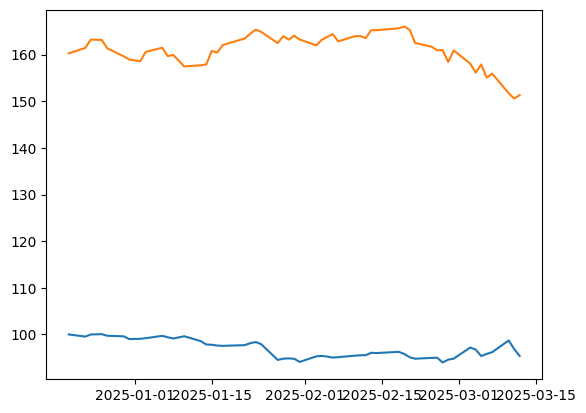

In [23]:
import polars as pl
import matplotlib.pyplot as plt

plt.plot(df['date'], df['close_price'].to_numpy())
plt.plot(df_1['date'], df_1['close_price'].to_numpy())

In [24]:
def get_factor_betas(ticker_str, ticker_returns, factor_dict):   
    # Prepare design matrix from factor returns.
    factor_names = list(factor_dict.keys())
    factors = np.column_stack([factor_dict[f] for f in factor_names])
    
    # Add constant for the intercept.
    X = sm.add_constant(factors)
    y = ticker_returns
    
    # Run the OLS regression.
    model = sm.OLS(y, X).fit()
    
    # Initialize betas dictionary with the intercept labeled as ALPHA.
    betas = {
        "ALPHA": {
            "factor": "ALPHA",
            "coefficient": model.params[0],
            "pval": model.pvalues[0]
        }
    }
    
    # Append betas for the other factors.
    for i, factor in enumerate(factor_names, start=1):
        betas[factor] = {
            "factor": factor,
            "coefficient": model.params[i],
            "pval": model.pvalues[i]
        }
    
    return {
        ticker_str: {
            "betas": betas,
            "residual_vector": model.resid
        }
    }

In [25]:
spx

date,close_price,returns,100DayMA
date,f64,f64,f64
2024-10-16,5842.470215,0.004679,5532.814692
2024-10-17,5841.470215,-0.000171,5538.182192
2024-10-18,5864.669922,0.003972,5543.768491
2024-10-21,5853.97998,-0.001823,5549.638789
2024-10-22,5851.200195,-0.000475,5555.795991
…,…,…,…
2025-03-06,5738.52002,-0.017819,5954.767793
2025-03-07,5770.200195,0.005521,5954.669297
2025-03-10,5614.560059,-0.026973,5952.6646


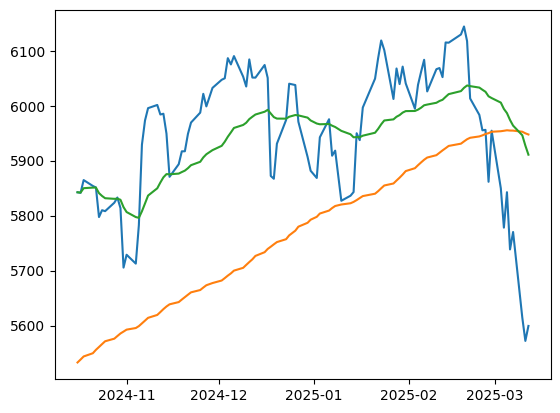

In [30]:
plt.plot(spx['date'], spx['close_price'])
plt.plot(spx['date'], spx['100DayMA'])
plt.plot(spx['date'], spx['close_price'].ewm_mean(alpha=0.05))

In [65]:
pl.DataFrame(ticker_data['K'])

date,close_price,returns
date,f64,f64
2024-10-28,80.034836,0.0
2024-10-29,80.005051,-0.000372
2024-10-30,80.283081,0.003475
2024-10-31,80.084488,-0.002474
2024-11-01,80.044769,-0.000496
…,…,…
2025-02-24,82.720001,0.000726
2025-02-25,82.690002,-0.000363
2025-02-26,82.620003,-0.000847


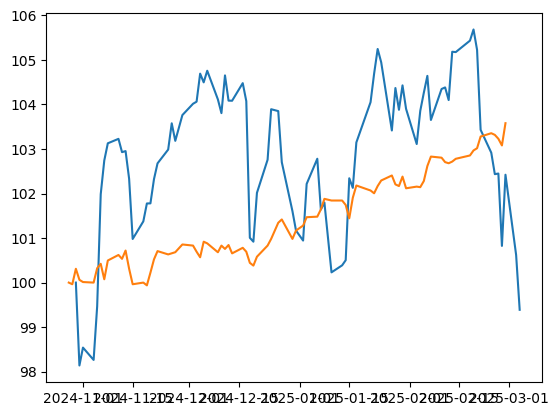

In [63]:

gild = pl.DataFrame(ticker_data['K'])
gild = gild.with_columns(pl.col('close_price')/gild['close_price'][0]*100).with_columns(pl.col('close_price')/df_1['close_price'][0]*100)
df_1 = pl.DataFrame(market_factor)
df_1 = df_1.filter(pl.col('date').is_in(df_1['date'])).with_columns(pl.col('close_price')/df_1['close_price'][0]*100)
plt.plot(df_1['date'], df_1['close_price'])
plt.plot(gild['date'], gild['close_price'])

In [64]:
np.corrcoef(df_1['close_price'].to_numpy(), gild['close_price'].to_numpy())

array([[1.        , 0.27678125],
       [0.27678125, 1.        ]])

In [31]:
def get_betas (ticker):    
    pltr = pl.DataFrame(ticker_data[ticker]).filter(pl.col('date').is_in(df['date']))
    ticker_returns = pltr['returns'].to_numpy()
    factor_dict = {
        'MARKET': df_1['returns'].to_numpy(),
        'MOMENTUM': df['returns'].to_numpy()
    }
    result = get_factor_betas(ticker, ticker_returns, factor_dict)
    return result



# Example usage
tickers = list(ticker_data.keys())
beta_results = [get_betas(ticker) for ticker in tqdm(tickers)]

100%|██████████| 501/501 [00:00<00:00, 638.33it/s]


In [32]:
def flatten_dict(nested_dict):
    result = {}
    
    for ticker, data in nested_dict.items():
        betas = data['betas']
        result.update({
            'ticker': ticker,
            'alpha': betas['ALPHA']['coefficient'],
            'alpha_pval': betas['ALPHA']['pval'],
            'market_beta': betas['MARKET']['coefficient'],
            'market_pval': betas['MARKET']['pval'],
            'momentum_beta': betas['MOMENTUM']['coefficient'],
            'momentum_pval': betas['MOMENTUM']['pval']
        })
    return result

beta_results_f = pl.DataFrame([flatten_dict(d) for d in beta_results])

In [33]:
beta_results_f.sort('alpha', descending=True).filter((pl.col('alpha_pval') < 0.05) & (pl.col('market_beta')<1) & (pl.col('market_pval')>0.05))

ticker,alpha,alpha_pval,market_beta,market_pval,momentum_beta,momentum_pval
str,f64,f64,f64,f64,f64,f64
"""CVS""",0.008104,0.032182,0.583854,0.131678,-0.291882,0.487528
"""VRTX""",0.004582,0.033968,0.320257,0.147569,0.092677,0.699241
"""GILD""",0.004535,0.043773,0.170895,0.455344,0.133194,0.594748
"""ABBV""",0.004072,0.040098,-0.038285,0.84909,-0.118926,0.589891
"""K""",0.00062,0.01985,0.02599,0.334702,0.028849,0.328282


In [36]:
beta_results_f.sort('momentum_beta', descending=True)

ticker,alpha,alpha_pval,market_beta,market_pval,momentum_beta,momentum_pval
str,f64,f64,f64,f64,f64,f64
"""CEG""",0.004116,0.588652,2.114945,0.009377,1.721871,0.050037
"""VST""",0.003944,0.585495,3.387849,0.000033,1.528263,0.066527
"""ANET""",-0.001442,0.770298,2.764762,0.000002,1.066071,0.0614
"""ORCL""",0.001432,0.651783,2.472257,6.9124e-10,1.0286,0.005881
"""GEV""",0.002459,0.621327,3.034865,2.7108e-7,0.992691,0.082909
…,…,…,…,…,…,…
"""NOW""",-0.003875,0.19161,1.242542,0.00015,-0.875199,0.011123
"""CE""",-0.003915,0.49061,0.453099,0.441413,-0.922543,0.155321
"""INTU""",-0.001206,0.664538,0.833831,0.005327,-0.931001,0.004559


In [ ]:
set(sp500_tickers['GICS Sub-Industry'].unique())

In [ ]:
plt.plot(ts['date'], ts['close_price'].to_numpy())

In [ ]:
from tabulate import tabulate

def print_factor_table(data):
    rows = []
    for ticker, ticker_data in data.items():
        for factor_name, factor_data in ticker_data['betas'].items():
            rows.append([
                ticker,
                factor_data['factor'],
                round(factor_data['coefficient'], 4),
                round(factor_data['pval'], 4)
            ])
    
    headers = ["Ticker", "Factor", "Coefficient", "p-value"]
    return tabulate(rows, headers=headers, tablefmt="grid")

